In [ ]:
#Downloads
#nltk.download('punkt')
#nltk.download("stopwords")
#SENT_DETECTOR = nltk.data.load('tokenizers/punkt/english.pickle')
#nltk.download('averaged_perceptron_tagger')
#!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall
#!pip install spacy==2.2.3
#!python -m spacy download en_core_web_sm
#!pip install beautifulsoup4==4.9.1
#!pip install textblob==0.15.3
#!pip install wordcloud

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import string
import nltk
import seaborn as sns
import random
import requests
from math import sqrt
from bs4 import BeautifulSoup
from datetime import datetime
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.util import ngrams
from nltk import pos_tag
from collections import Counter
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (RandomForestClassifier, 
                              GradientBoostingClassifier, AdaBoostClassifier,
                              RandomForestRegressor, GradientBoostingRegressor, 
                              AdaBoostRegressor)
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from xgboost import XGBClassifier,  XGBRegressor
from sklearn.metrics import accuracy_score, classification_report, roc_curve
from sklearn import linear_model
from sklearn import metrics
from sklearn.dummy import DummyRegressor
from src.functions import *

# Article Title Popularity Predictor

## Load and Vectorize Article Titles

In [49]:
#Instanciate NLP Class
nlp = NLP()

#Load in Regression Data Frame from csv file
df_pop_reg = pd.read_csv('data/df_supervised_regression_models.csv')

#Load in Classification Data Frame from csv file
df_pop_cla = pd.read_csv('data/df_supervised_classification_models.csv')

#Load in fully scraped article text Data Frame
df_pop_text = pd.read_csv('data/pop_text_medium.csv')

#Vectorize the article titles 
df_tfidf_reg_title = nlp.vectorize(df_pop_reg, 'title')
df_tfidf_cla_title = nlp.vectorize(df_pop_cla, 'title')

#Vectorize the article text 
df_tfidf_reg_text = nlp.vectorize(df_pop_text, 'text')
df_tfidf_cla_text = nlp.vectorize(df_pop_text, 'text')

#Save both CSV Files
#df_tfidf_reg.to_csv('data/df_tfidf_reg.csv')
#df_tfidf_cla.to_csv('data/df_tfidf_cla.csv')

#Load both CSV Files
#df_tfidf_reg = pd.read_csv('data/df_tfidf_reg.csv')
#df_tfidf_cla = pd.read_csv('data/df_tfidf_cla.csv')

## Regression Model: Article Titles

The RMSE of model DummyRegressor is 501.37


The RMSE of model Ridge is 503.83


The RMSE of model DecisionTreeRegressor is 614.48


The RMSE of model RandomForestRegressor is 563.03


The RMSE of model KNeighborsRegressor is 550.17


The RMSE of model XGBRegressor is 558.83


The RMSE of model GradientBoostingRegressor is 547.08




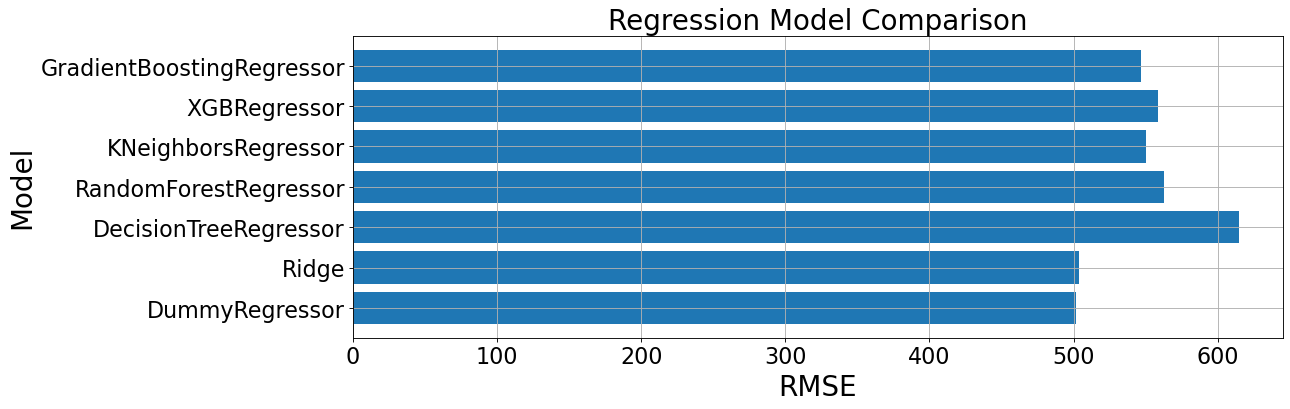

In [55]:
#Split the data and target
X = df_tfidf_reg_title
y = df_pop_reg['claps']

#Train, test and split the data
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size= 0.2, random_state=1)

# Initialize the regression models using the random state for reproducibility
dummy_reg = DummyRegressor()
ridge_reg = linear_model.Ridge()
tree_reg= DecisionTreeRegressor(random_state=1) 
forest_reg= RandomForestRegressor(random_state=1)
knn_reg= KNeighborsRegressor(n_neighbors=5)
xboost_reg= XGBRegressor(random_state=1)
gboost_reg = GradientBoostingRegressor(random_state=1) 

# now, create a list with the regression objects 
reg_models= [dummy_reg, ridge_reg, tree_reg, forest_reg, knn_reg,
             xboost_reg, gboost_reg]

#Run and evaluate the results
rmse_dict = nlp.evaluate_reg_models(reg_models, X_train, y_train, X_test, y_test)     

## Classification Model: Article Titles

The accuracy of model DecisionTreeClassifier is 0.25
The Precision of model DecisionTreeClassifier is 0.23
The Recall of model DecisionTreeClassifier is 0.25
The F1-Score of model DecisionTreeClassifier is 0.23


The accuracy of model RandomForestClassifier is 0.45
The Precision of model RandomForestClassifier is 0.40
The Recall of model RandomForestClassifier is 0.45
The F1-Score of model RandomForestClassifier is 0.37


The accuracy of model KNeighborsClassifier is 0.50
The Precision of model KNeighborsClassifier is 0.50
The Recall of model KNeighborsClassifier is 0.50
The F1-Score of model KNeighborsClassifier is 0.48




/home/louisbove84/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:36:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The accuracy of model XGBClassifier is 0.45
The Precision of model XGBClassifier is 0.45
The Recall of model XGBClassifier is 0.45
The F1-Score of model XGBClassifier is 0.44


The accuracy of model GradientBoostingClassifier is 0.35
The Precision of model GradientBoostingClassifier is 0.34
The Recall of model GradientBoostingClassifier is 0.35
The F1-Score of model GradientBoostingClassifier is 0.34


The accuracy of model AdaBoostClassifier is 0.45
The Precision of model AdaBoostClassifier is 0.45
The Recall of model AdaBoostClassifier is 0.45
The F1-Score of model AdaBoostClassifier is 0.45




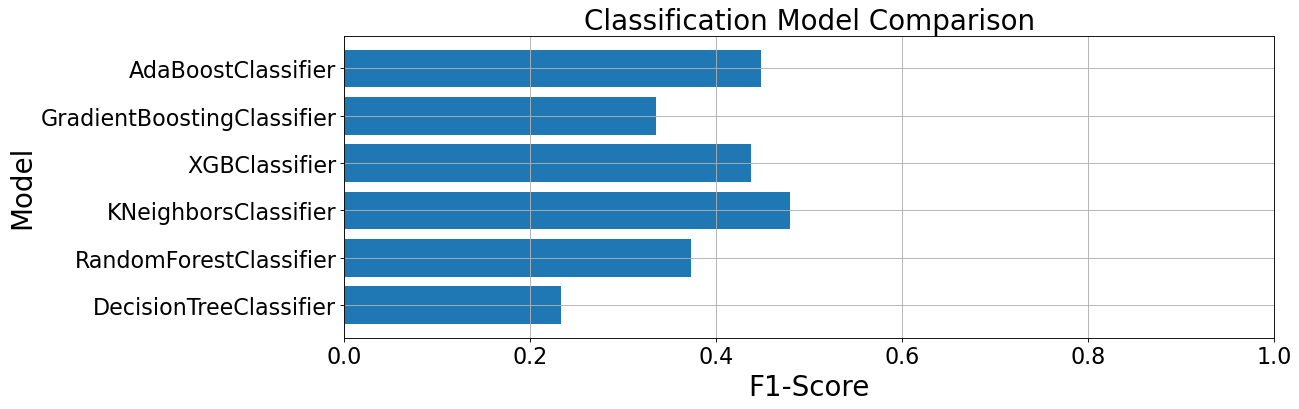

In [56]:
#Split the data and target
X = df_tfidf_cla_title
y = df_pop_cla['popular']

#Train, test and split the data
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size= 0.2, random_state=1)

# Initialize the classificators
tree= DecisionTreeClassifier(random_state=1) 
forest= RandomForestClassifier(random_state=1)
knn= KNeighborsClassifier(n_neighbors=5)
xboost= XGBClassifier(random_state=1)
gboost = GradientBoostingClassifier(random_state=1) 
adaboost = AdaBoostClassifier(random_state=1)

# now, create a list with the objects 
cla_models= [tree, forest, knn, xboost, gboost, adaboost]

#Run and evaluate the results
cla_results_dict = nlp.evaluate_cla_models(cla_models,X_train, y_train, X_test, y_test)

In [26]:
#ROC Curve???
#sklearn.metrics.roc_curve


# Article Text Popularity Predictor

## Regression Model: Full Article Text

The RMSE of model DummyRegressor is 501.37


The RMSE of model Ridge is 498.01


The RMSE of model DecisionTreeRegressor is 423.31


The RMSE of model RandomForestRegressor is 478.52


The RMSE of model KNeighborsRegressor is 517.49


The RMSE of model XGBRegressor is 471.32


The RMSE of model GradientBoostingRegressor is 428.69




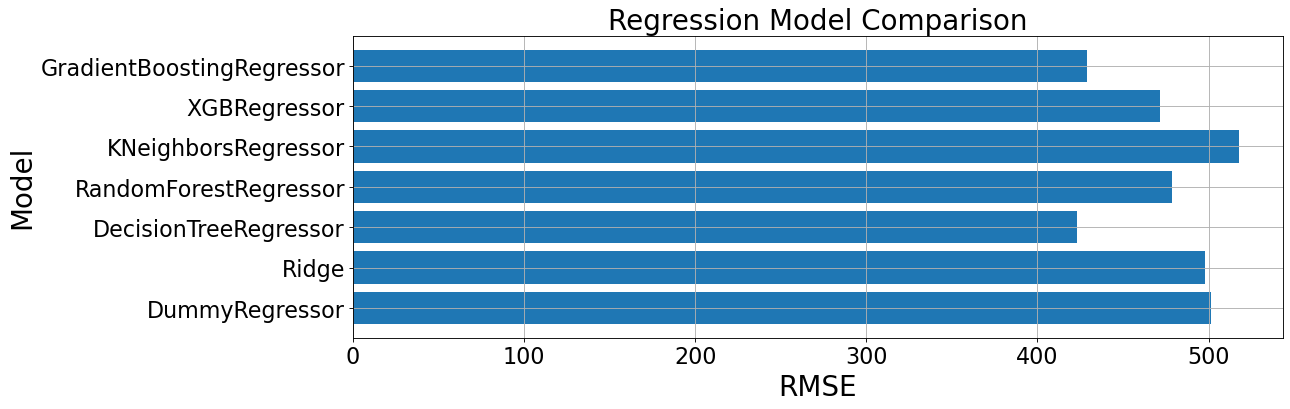

In [57]:
#Split the data and target
X = df_tfidf_reg_text
y = df_pop_reg['claps']

#Train, test and split the data
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size= 0.2, random_state=1)

#Run and evaluate the results
rmse_dict = nlp.evaluate_reg_models(reg_models, X_train, y_train, X_test, y_test) 

## Classification Model: Full Article Text

The accuracy of model DecisionTreeClassifier is 0.35
The Precision of model DecisionTreeClassifier is 0.35
The Recall of model DecisionTreeClassifier is 0.35
The F1-Score of model DecisionTreeClassifier is 0.35


The accuracy of model RandomForestClassifier is 0.40
The Precision of model RandomForestClassifier is 0.40
The Recall of model RandomForestClassifier is 0.40
The F1-Score of model RandomForestClassifier is 0.39


The accuracy of model KNeighborsClassifier is 0.50
The Precision of model KNeighborsClassifier is 0.50
The Recall of model KNeighborsClassifier is 0.50
The F1-Score of model KNeighborsClassifier is 0.48




/home/louisbove84/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:37:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The accuracy of model XGBClassifier is 0.45
The Precision of model XGBClassifier is 0.45
The Recall of model XGBClassifier is 0.45
The F1-Score of model XGBClassifier is 0.44


The accuracy of model GradientBoostingClassifier is 0.45
The Precision of model GradientBoostingClassifier is 0.45
The Recall of model GradientBoostingClassifier is 0.45
The F1-Score of model GradientBoostingClassifier is 0.45


The accuracy of model AdaBoostClassifier is 0.45
The Precision of model AdaBoostClassifier is 0.45
The Recall of model AdaBoostClassifier is 0.45
The F1-Score of model AdaBoostClassifier is 0.45




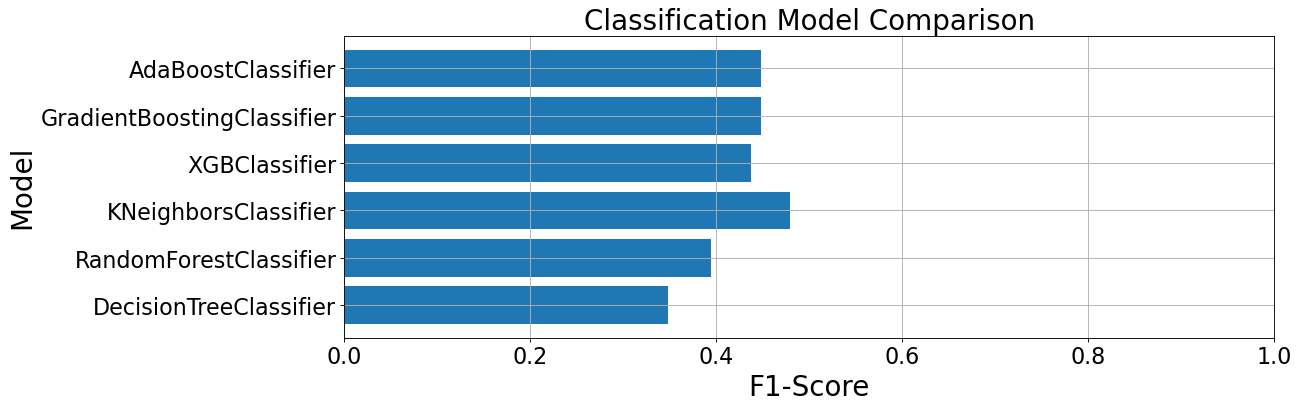

In [58]:
#Split the data and target
X = df_tfidf_cla_text
y = df_pop_cla['popular']

#Train, test and split the data
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size= 0.2, random_state=1)

#Run and evaluate the results
cla_results_dict = nlp.evaluate_cla_models(cla_models, X_train, y_train, X_test, y_test)

In [ ]:
#diabetes = datasets.load_diabetes()
#X = diabetes.data[:150]
#y = diabetes.target[:150]
#lasso = linear_model.Lasso()
#print(cross_val_score(lasso, X, y, cv=3))
#[0.33150734 0.08022311 0.03531764]

In [ ]:
#Mean Absolute Error (MAE): This measures the absolute average distance between the real data and 
#the predicted data, but it fails to punish large errors in prediction.

#Mean Square Error (MSE): This measures the squared average distance between the real data and the
#predicted data. Here, larger errors are well noted (better than MAE). But the disadvantage is that
#it also squares up the units of data as well. So, evaluation with different units is not at all justified.

#Root Mean Squared Error (RMSE): This is actually the square root of MSE. Also, this metrics solves 
#the problem of squaring the units.

#The definition of R-squared is fairly straight-forward; it is the percentage of the response variable variation that is explained by a linear model. Or:

#R-squared = Explained variation / Total variation

#R-squared is always between 0 and 100%:

#    0% indicates that the model explains none of the variability of the response data around its mean.
#    100% indicates that the model explains all the variability of the response data around its mean.